In [1194]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

from tqdm import tqdm, trange

In [1195]:
from pathlib import Path

DATA_DIR = Path("../data/")

def read_dataset_file(path: Path) -> np.lib.npyio.NpzFile:
    return np.load(file=path, allow_pickle=True)

metr_la = read_dataset_file(DATA_DIR / "metr_la_new.npz")
metr_la

NpzFile '../data/metr_la_new.npz' with keys: num_timestamps, num_nodes, first_timestamp_datetime, last_timestamp_datetime, timestamp_frequency...

In [1196]:
metr_la["timestamp_frequency"].item()

datetime.timedelta(seconds=300)

In [1197]:
EDGES_KEY = "edges"
TARGETS_KEY = "targets"
SPATIAL_FEATURES_KEY = "spatial_node_features"

In [1198]:
metr_la[EDGES_KEY]

array([[  0,  37],
       [  0,  54],
       [  0, 116],
       ...,
       [206, 155],
       [206, 159],
       [206, 163]], dtype=int32)

In [1199]:
metr_la

NpzFile '../data/metr_la_new.npz' with keys: num_timestamps, num_nodes, first_timestamp_datetime, last_timestamp_datetime, timestamp_frequency...

In [1200]:
metr_la_targets = metr_la[TARGETS_KEY]
metr_la_coords = metr_la[SPATIAL_FEATURES_KEY]
metr_la_targets.shape

(34272, 207)

In [1201]:
window_size_1_hr = 12 * 24

kernel_averager = np.ones(window_size_1_hr) / window_size_1_hr
# print(f"{kernel_averager=}")


# 1) NaN - ???? --> replace nans 
# Replace strategies - mean, median, last value, [0 !!!!]

#тут мы решили заполнить нулями nans 
metr_la__targets_transposed = np.nan_to_num(metr_la_targets, 0).T
metr_la__targets_transposed.shape

math_expectation = np.zeros(207)  # expectation OR mean
for i in range(207):
    sum_sensors = 0
    for j in range(metr_la__targets_transposed.shape[1]):  # /// HERE!!!!
        sum_sensors += metr_la__targets_transposed[i][j]
    sum_sensors /= metr_la__targets_transposed.shape[1]
    math_expectation[i] = sum_sensors
math_expectation.shape

(207,)

In [1202]:
def get_coverage(array_x: list, array_y: list, x_math: int, y_math: int, count = 207, timestamps_cap = 34272):
    cov = 0
    for i in range(timestamps_cap):
        cov += (array_x[i] - x_math) * (array_y[i] - y_math)
    return cov


In [1203]:
print(get_coverage(metr_la__targets_transposed[0], metr_la__targets_transposed[1], math_expectation[0], math_expectation[1]))

7895488.968878485


In [1204]:
def get_dispersion(array: list, math_x: int, count = 207, timestamps_cap = 34272):
    dispersion = 0
    for i in range(timestamps_cap):
        dispersion += (array[i] - math_x) ** 2
    return np.sqrt(dispersion)

In [1205]:
def get_correlation(array_x: list, array_y: list, x_math: int, y_math: int, count = 207):
    return get_coverage(array_x, array_y, x_math, y_math) / (get_dispersion(array_x, x_math) * get_dispersion(array_y, y_math))

In [1206]:
print(get_correlation(metr_la__targets_transposed[0], metr_la__targets_transposed[1], math_expectation[0], math_expectation[1]))

0.6377693185023642


In [1207]:
def get_all_correlation(array_x_y: list, array_x_math: list, count = 207):
    ans_matrix = np.zeros((count, count))
    for i in trange(count):
        for j in range(i, count):
            ans_matrix[i, j] = ans_matrix[j, i] = get_correlation(array_x_y[i], array_x_y[j], array_x_math[i], array_x_math[j])
    return ans_matrix

In [1208]:
matrix = np.corrcoef(metr_la__targets_transposed)
matrix

array([[1.        , 0.63776932, 0.51020576, ..., 0.56631208, 0.58506304,
        0.48917555],
       [0.63776932, 1.        , 0.84697142, ..., 0.86088827, 0.80049981,
        0.62187005],
       [0.51020576, 0.84697142, 1.        , ..., 0.8705897 , 0.67544606,
        0.57938259],
       ...,
       [0.56631208, 0.86088827, 0.8705897 , ..., 1.        , 0.73088846,
        0.66675078],
       [0.58506304, 0.80049981, 0.67544606, ..., 0.73088846, 1.        ,
        0.59488127],
       [0.48917555, 0.62187005, 0.57938259, ..., 0.66675078, 0.59488127,
        1.        ]])

In [1209]:
corrcoeff_ground_truth = np.corrcoef(metr_la__targets_transposed)

In [1210]:
np.corrcoef(metr_la__targets_transposed)

array([[1.        , 0.63776932, 0.51020576, ..., 0.56631208, 0.58506304,
        0.48917555],
       [0.63776932, 1.        , 0.84697142, ..., 0.86088827, 0.80049981,
        0.62187005],
       [0.51020576, 0.84697142, 1.        , ..., 0.8705897 , 0.67544606,
        0.57938259],
       ...,
       [0.56631208, 0.86088827, 0.8705897 , ..., 1.        , 0.73088846,
        0.66675078],
       [0.58506304, 0.80049981, 0.67544606, ..., 0.73088846, 1.        ,
        0.59488127],
       [0.48917555, 0.62187005, 0.57938259, ..., 0.66675078, 0.59488127,
        1.        ]])

In [1211]:
graph = metr_la[EDGES_KEY]
graph[10]

array([2, 1], dtype=int32)

In [1212]:
matrix

array([[1.        , 0.63776932, 0.51020576, ..., 0.56631208, 0.58506304,
        0.48917555],
       [0.63776932, 1.        , 0.84697142, ..., 0.86088827, 0.80049981,
        0.62187005],
       [0.51020576, 0.84697142, 1.        , ..., 0.8705897 , 0.67544606,
        0.57938259],
       ...,
       [0.56631208, 0.86088827, 0.8705897 , ..., 1.        , 0.73088846,
        0.66675078],
       [0.58506304, 0.80049981, 0.67544606, ..., 0.73088846, 1.        ,
        0.59488127],
       [0.48917555, 0.62187005, 0.57938259, ..., 0.66675078, 0.59488127,
        1.        ]])

In [1213]:
graph_in_matrix = np.zeros((207, 207))
for edge in graph:
    graph_in_matrix[edge[0], edge[1]] = 1

In [1214]:
graph_in_matrix # рисуем матрицу смежности

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1215]:
correlations_with_edges = np.zeros((207, 207))
for i in range(len(graph_in_matrix)):
    for j in range(len(graph_in_matrix[0])):
        correlations_with_edges[i][j] = graph_in_matrix[i][j] * matrix[i][j]
correlations_with_edges # корреляции только для ребер графа

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.84697142, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.84697142, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

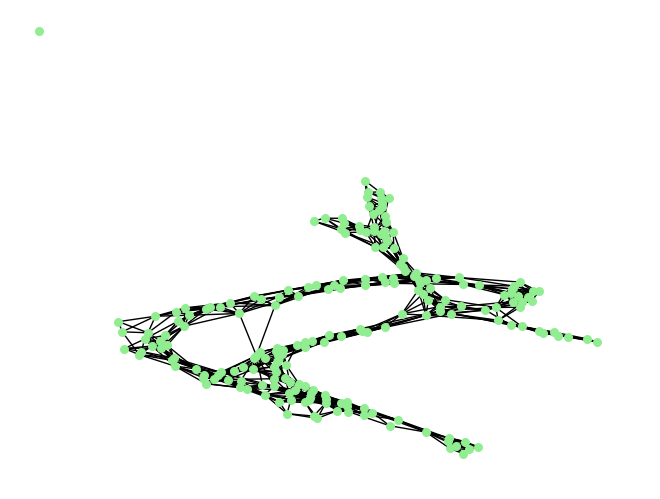

In [1216]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Создание графа
G = nx.from_numpy_array(graph_in_matrix)

# Рисование графа
nx.draw(G, with_labels=False, node_size=30, node_color='lightgreen', node_shape='o', font_size=5)
plt.show()

In [1217]:
!pip install folium

In [1218]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[34.052235, -118.243683],
               zoom_start=11,
               tiles='cartodbpositron')

metr_la_targets = metr_la[TARGETS_KEY]
metr_la_targets

array([[64.375   , 67.625   , 67.125   , ..., 59.25    , 69.      ,
        61.875   ],
       [62.666668, 68.55556 , 65.44444 , ..., 55.88889 , 68.44444 ,
        62.875   ],
       [64.      , 63.75    , 60.      , ..., 61.375   , 69.85714 ,
        62.      ],
       ...,
       [67.      , 59.666668, 69.55556 , ..., 63.333332, 67.44444 ,
        61.22222 ],
       [66.75    , 62.25    , 66.      , ..., 63.      , 67.875   ,
        63.5     ],
       [65.111115, 66.888885, 66.77778 , ..., 63.555557, 68.666664,
        61.77778 ]], dtype=float32)

In [1219]:
timestamps = pd.date_range(start=metr_la["first_timestamp_datetime"].item(),
                           end=metr_la["last_timestamp_datetime"].item(),
                           freq="5min",
                           )
timestamps

DatetimeIndex(['2012-03-01 00:00:00', '2012-03-01 00:05:00',
               '2012-03-01 00:10:00', '2012-03-01 00:15:00',
               '2012-03-01 00:20:00', '2012-03-01 00:25:00',
               '2012-03-01 00:30:00', '2012-03-01 00:35:00',
               '2012-03-01 00:40:00', '2012-03-01 00:45:00',
               ...
               '2012-06-27 23:10:00', '2012-06-27 23:15:00',
               '2012-06-27 23:20:00', '2012-06-27 23:25:00',
               '2012-06-27 23:30:00', '2012-06-27 23:35:00',
               '2012-06-27 23:40:00', '2012-06-27 23:45:00',
               '2012-06-27 23:50:00', '2012-06-27 23:55:00'],
              dtype='datetime64[ns]', length=34272, freq='5T')

In [1220]:
time_ = 0
metr_la_coords = metr_la[SPATIAL_FEATURES_KEY]

metr_la_coords[0]

get_node = {}
for i in range(len(metr_la_coords[0])):
    get_node[tuple(metr_la_coords[0][i])] = i
get_node

{(34.15497, -118.31829): 0,
 (34.11621, -118.23799): 1,
 (34.11641, -118.23819): 2,
 (34.07248, -118.26772): 3,
 (34.07142, -118.26572): 4,
 (34.06913, -118.25932): 5,
 (34.05368, -118.23369): 6,
 (34.13486, -118.22932): 7,
 (34.20264, -118.47352): 8,
 (34.15562, -118.4686): 9,
 (34.16415, -118.38223): 10,
 (34.15691, -118.22469): 11,
 (34.07821, -118.28795): 12,
 (34.1566, -118.30266): 13,
 (34.18949, -118.47437): 14,
 (34.07006, -118.26246): 15,
 (34.07314, -118.23388): 16,
 (34.07732, -118.28186): 17,
 (34.20672, -118.19992): 18,
 (34.12095, -118.33911): 19,
 (34.12073, -118.33928): 20,
 (34.20584, -118.19803): 21,
 (34.12634, -118.34482): 22,
 (34.05767, -118.21435): 23,
 (34.15478, -118.27076): 24,
 (34.12121, -118.27164): 25,
 (34.09478, -118.47605): 26,
 (34.12967, -118.22871): 27,
 (34.12964, -118.22901): 28,
 (34.0839, -118.22086): 29,
 (34.08374, -118.22076): 30,
 (34.17878, -118.39469): 31,
 (34.11027, -118.33441): 32,
 (34.06664, -118.25397): 33,
 (34.18784, -118.47407): 34

In [1221]:
df = pd.DataFrame(metr_la_coords[0], columns=['latitude', 'longitude'])
#HeatMap(df, radius=10).add_to(m)

In [1222]:
m

In [1223]:
!pip install osmnx
!pip install shapely
import shapely
import osmnx
from shapely.geometry import Point, Polygon, LineString
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, GeometryCollection, LineString
import json
multipoints = MultiPoint([[a, b] for a, b in metr_la_coords[0]])
geojson = shapely.geometry.mapping(multipoints)
geojson

{'type': 'MultiPoint',
 'coordinates': ((34.15496826171875, -118.31829071044922),
  (34.1162109375, -118.23799133300781),
  (34.11640930175781, -118.23818969726562),
  (34.072479248046875, -118.2677230834961),
  (34.07141876220703, -118.26571655273438),
  (34.069129943847656, -118.25932312011719),
  (34.053680419921875, -118.23368835449219),
  (34.13486099243164, -118.22931671142578),
  (34.202640533447266, -118.47351837158203),
  (34.15562057495117, -118.46859741210938),
  (34.16415023803711, -118.38223266601562),
  (34.15690994262695, -118.22469329833984),
  (34.078208923339844, -118.28794860839844),
  (34.15660095214844, -118.30265808105469),
  (34.189491271972656, -118.47437286376953),
  (34.07006072998047, -118.26245880126953),
  (34.07313919067383, -118.23387908935547),
  (34.07732009887695, -118.2818603515625),
  (34.20671844482422, -118.19992065429688),
  (34.120948791503906, -118.339111328125),
  (34.120731353759766, -118.33927917480469),
  (34.205841064453125, -118.1980285644

In [1224]:
import colorsys

In [1225]:
time = 18*12 + 288 * 6
for i, point in enumerate(geojson['coordinates']):
    normal_vel = (metr_la_targets[time, i]) / 75
    folium.CircleMarker(list(point), radius=2, fill=True, color='green', fill_color='green', fill_opacity=0.3).add_to(m)
    #folium.PolyLine([[G.nodes[edge[0]]['lat'], G.nodes[edge[0]]['lon']], [G.nodes[edge[1]]['lat'], G.nodes[edge[1]]['lon']]], color=color).add_to(m)

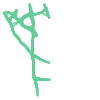

In [1226]:
metr_la_edges = metr_la[EDGES_KEY]
metr_la_edges
multiline = MultiLineString([LineString([Point(metr_la_coords[0][start]), Point(metr_la_coords[0][end])])
                            for start, end in metr_la_edges])
multiline

In [1227]:
geojson_line = shapely.geometry.mapping(multiline)
geojson_line

{'type': 'MultiLineString',
 'coordinates': (((34.15496826171875, -118.31829071044922),
   (34.15541076660156, -118.2957534790039)),
  ((34.15496826171875, -118.31829071044922),
   (34.15522003173828, -118.29344177246094)),
  ((34.15496826171875, -118.31829071044922),
   (34.15351104736328, -118.32750701904297)),
  ((34.15496826171875, -118.31829071044922),
   (34.156410217285156, -118.30265808105469)),
  ((34.15496826171875, -118.31829071044922),
   (34.155460357666016, -118.30841064453125)),
  ((34.1162109375, -118.23799133300781),
   (34.11640930175781, -118.23818969726562)),
  ((34.1162109375, -118.23799133300781),
   (34.13486099243164, -118.22931671142578)),
  ((34.1162109375, -118.23799133300781),
   (34.129638671875, -118.22901153564453)),
  ((34.1162109375, -118.23799133300781),
   (34.11296081542969, -118.24488830566406)),
  ((34.1162109375, -118.23799133300781),
   (34.119659423828125, -118.23143005371094)),
  ((34.11640930175781, -118.23818969726562),
   (34.1162109375, -11

In [1228]:
for line in geojson_line['coordinates']:
    first_node = get_node[tuple(line[0])]
    second_node = get_node[tuple(line[1])]
    hue = matrix[first_node][second_node]
    print(hue)
    #color = colorsys.hsv_to_rgb(1,1,(hue + 0.5)/1.5)
    #color = '#{:02x}{:02x}{:02x}'.format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    #folium.PolyLine([list(line[0]), list(line[1])], color = color, opacity= hue / 10).add_to(m)
    hue = (hue + 1) / 3.4  # нормализация веса от -1 до 1 к диапазону от 0 до 1
    if hue < 0.5:
        color = "green"  # зеленый градиент
        opacity_coef = 3
    else:
        color = 'red'
        opacity_coef = 4

    folium.PolyLine([list(line[0]), list(line[1])], color = color, opacity=hue / opacity_coef).add_to(m)
m

0.8459854025052982
0.7236166850180334
0.6665366623474217
0.679180564954758
0.7563893494369529
0.8469714165119767
0.7877069599398692
0.8482601292342139
0.8192892010502489
0.9647652423954286
0.8469714165119767
0.7081991713354514
0.9717319032633647
0.8308842910627321
0.9185313272721892
0.7365344064533909
0.7507433053315478
0.9353707985821375
0.9018876969535516
0.9697528808195324
0.7365344064533907
0.9604253308985479
0.8439701397952184
0.8171113611168945
0.7067127493039613
0.889257518144774
0.6351640574450048
0.8515041800955763
0.7664243827266134
0.8773047296314183
0.6830648027531755
0.9386555127732199
0.7582814606736695
0.8630671882331188
0.4895647752311685
0.9318202384729329
0.9412264528766139
0.6956497656438445
0.7438535312386789
0.590644905513481
0.8512616927778778
0.7759756702480051
0.8212554528468264
0.8965036188761615
0.9452226721752426
0.4512569462053646
0.5653451042641984
0.4073216962456124
0.42210176687171586
0.33682106340136403
0.8249616631271354
0.7120661454557722
0.71028670882

In [1229]:
import plotly.express as px

In [1230]:
px.imshow(matrix)

In [1231]:
px.imshow(correlations_with_edges)